【数据背景】新能源车电池模组的充放电数据是指电池在使用过程中进行充电和放电时所记录的相关信息。这些数据包含了电池的性能指标、工作状态和使用情况，可以帮助监测和评估电池的健康状况、性能表现以及寿命预测。这些数据通过车辆的电池管理系统（Battery Management System，简称BMS）进行监测和记录。基于这些数据，制造商和维护人员可以进行电池性能分析、故障诊断以及优化电池使用和充电策略。同时，这些数据也可以用于研究和改进电池技术，提高新能源车的续航里程和可靠性。

【应用领域】AI+电池充放电

【文件目录】20个#x的csv数据文件（比如第一辆的名称就是#1.csv）

【数据说明】共20辆新能源车的电池模组充放电数据，每个#x代表一辆新能源车电池模组的充放电数据，数据时间段为2019/07/25—2021/11/15，数据跨度约29个月，数据集大小约1.1GB。每个csv数据表包含10个数据字段，具体如下：

1. record_time：时间戳
2. soc：车辆电池剩余容量，单位为%
3. pack_voltage：电池模组电压，单位为V
4. charge_current：充电电流，单位为A
5. max_cell_voltage：电池单体最大电压，单位为V
6. min_cell_voltage：电池单体最小电压，单位为V
7. max_temperature：最高温度，单位为℃
8. min_temperature：最低温度，单位为℃
9. available_energy：可用能量，单位为kW
10. available_capacity：可用容量，单位为Ah

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 导入所有的CSV文件  
PATH = "D:/New-Energy-Battery/dataset/"

data_files = glob.glob(PATH + "/*.csv")  # Assuming CSV files are in the current directory

def Data_DF():
    def Generate_DF(Data_Files):
        dataframes = []
        for file in Data_Files:
            df = pd.read_csv(file)
            df = df.iloc[:, 1:] # 去掉第一行
            # 追加文件名作为列以便之后区分不同车辆
            df['vehicle_id'] = file.split('\\')[-1].split(".")[0]  # 获取文件名作为车辆识别
            dataframes.append(df)
        return dataframes
    # 合并所有数据框
    data = pd.concat(Generate_DF(data_files), ignore_index=True)

    # - 将record_time转换为datetime格式  
    data['record_time'] = pd.to_datetime(data['record_time'], format='%Y%m%d%H%M%S', errors='coerce')

    # - 删除缺失值
    data.dropna(inplace=True)

    # 排序数据
    data.sort_values(by='record_time', inplace=True)
    data.reset_index(drop=True, inplace=True)

    print(data.info())

    return data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16100728 entries, 0 to 16100727
Data columns (total 11 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   record_time              datetime64[ns]
 1   soc                      float64       
 2   pack_voltage (V)         float64       
 3   charge_current (A)       float64       
 4   max_cell_voltage (V)     float64       
 5   min_cell_voltage (V)     float64       
 6   max_temperature (℃)      int64         
 7   min_temperature (℃)      int64         
 8   available_energy (kw)    float64       
 9   available_capacity (Ah)  float64       
 10  vehicle_id               object        
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 1.3+ GB
None
Epoch 1/5
316984/316984 [==============================] - 554s 2ms/step - loss: 4.8180 - val_loss: 0.7597
Epoch 2/5
316984/316984 [==============================] - 417s 1ms/step - loss: 0.7440 - val_loss: 0.7075


D:\Python311_pip\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


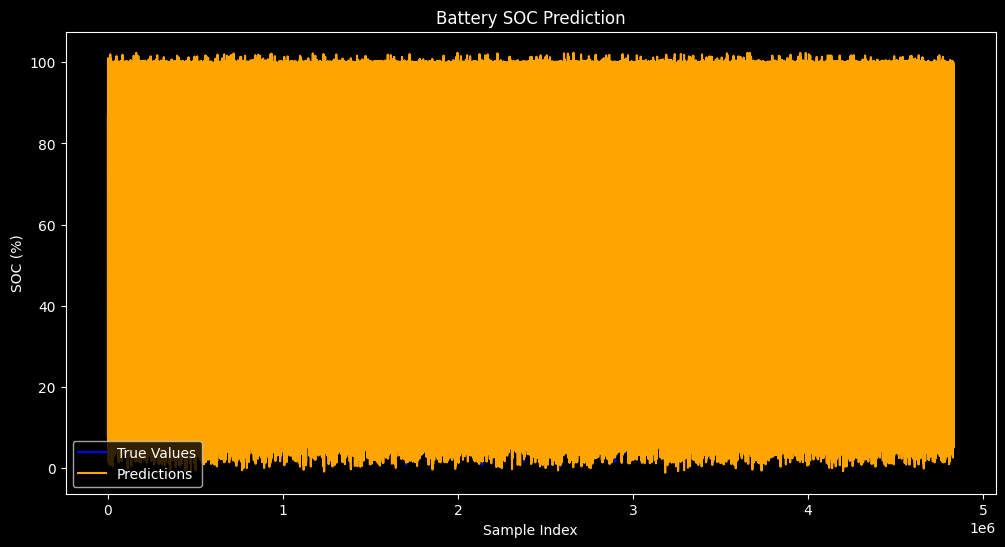

In [5]:
def Data_Scaler():
    # 选择特征和标签

    # 归一化数据
    scaler = MinMaxScaler()
    Data = Data_DF()
    features = Data[
        [
            "pack_voltage (V)",
            "charge_current (A)",
            "max_cell_voltage (V)",
            "min_cell_voltage (V)",
            "max_temperature (℃)",
            "min_temperature (℃)",
            "available_energy (kw)",
            "available_capacity (Ah)",
        ]
    ].values
    labels = Data["soc"].values  # 这里选择soc作为标签
    features_scaled = scaler.fit_transform(features)
    return features_scaled, labels

X_test = None
y_test = None

def Split():
    global X_test, y_test
    feature_data, label_data = Data_Scaler()
    # 3. 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        feature_data, label_data, test_size=0.3, random_state=42
    )
    # 将数据reshape为RNN所需的格式
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, y_train


def RNN_Model():
    X_train, y_train = Split()
    # 4. 构建RNN模型
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.SimpleRNN(
            64, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(tf.keras.layers.Dense(1))  # 输出层

    # 5. 编译模型
    model.compile(optimizer="adam", loss="mse")

    # 6. 训练模型
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

    return model

# 7. 评估模型
predictions = RNN_Model().predict(X_test)

# 8. 可视化结果
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="True Values", color="blue")
plt.plot(predictions, label="Predictions", color="orange")
plt.title("Battery SOC Prediction")
plt.xlabel("Sample Index")
plt.ylabel("SOC (%)")
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import r2_score
print("Accuracy rate:", r2_score(y_test, predictions))

Accuracy rate: 0.9982973029090839


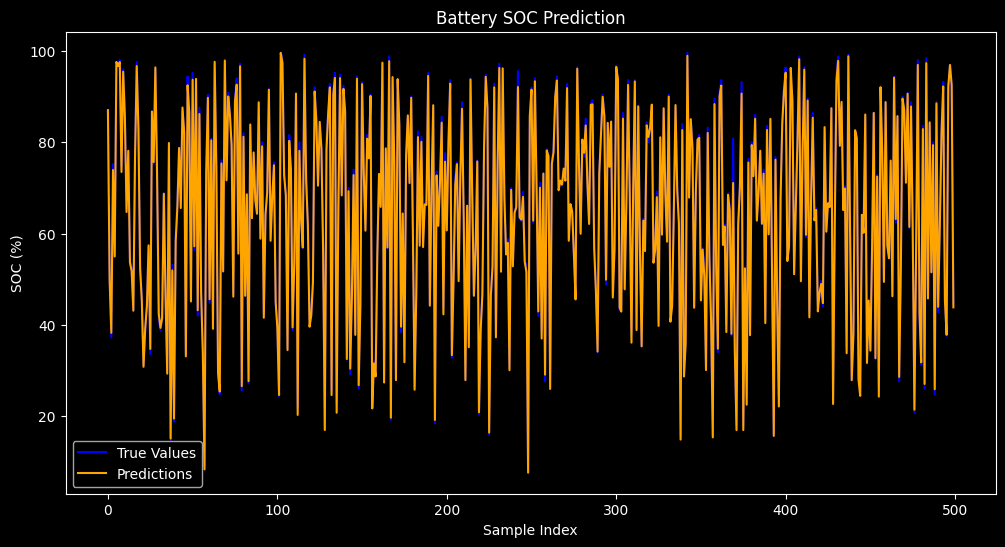

In [11]:
# 8. 可视化结果
Num = 500
plt.figure(figsize=(12, 6))
plt.plot(y_test[:Num], label="True Values", color="blue")
plt.plot(predictions[:Num], label="Predictions", color="orange")
plt.title("Battery SOC Prediction")
plt.xlabel("Sample Index")
plt.ylabel("SOC (%)")
plt.legend()
plt.show()